In [238]:
import numpy as np
import matplotlib.pyplot as plt

In [239]:
class Meteo:
    """classe pour representer le Markov Reward Process vu en cours
    1-gamma est la probabilité d'aller dans l'état terminal
    (équivalent à un discount sur les formules)"""
    
    def __init__(self, gamma):
        self.state_space = [0,1,2] #0 : Beau temps, 1 : Mauvais temps, 2:Terminal
        self.state = None
        self.gamma = gamma
        self.nb_states = 3
        self.rewards = [3, 1, 0.]
        self.transition_matrix = [[0.4*gamma,0.6*gamma, 1-gamma],
                                  [0.3*gamma,0.7*gamma,1-gamma],
                                  [0.,0.,1.]]
        self.terminal = [False, False, True]
        
    def reset(self):
        self.state = 0
        return self.state
    
    def step(self):
        """effectue un pas de temps et une transition sur le modèle
        return new_state, reward
        """
        if self.terminal[self.state]:
            raise Exception('Executer reset avant de faire un nouvel épisode')
        probas = self.transition_matrix[self.state]
        
        p_cumul = 0
        rew = self.rewards[self.state]
        r = np.random.random()
        for j in range(len(probas)):
            p_cumul += probas[j]
            if r <= p_cumul:
                self.state = j
                return j, rew, self.terminal[j], None

In [240]:
env = Meteo(0.8)


for i in range(500):
    state = env.reset()
    terminal = False
    #print(f's={state}', end = ' ')
    nb_trans = 0
    while not terminal:

        state, reward, terminal, info = env.step()
        #print(f'reward={reward}, s={state}', end = ' ')
    #print()


In [241]:
def gain_formule(env, gamma):
    """calcul de gain moyen de chaque sommet par la formule matricielle"""
    P = np.array(env.transition_matrix)[:2,:2]
    R = np.array(env.rewards).reshape(3,1)[:2,:]
    return np.linalg.inv(np.identity(2) - P).dot(R)

In [242]:
gains_exacts = gain_formule(env,0.8) ; gains_exacts

array([[9.7826087 ],
       [7.60869565]])

In [243]:
def first_visit_gain_MC(env, nb_episodes, gamma=1):
    suite_gains = [[] for i in range(env.nb_states)]
    for n in range(nb_episodes):
        rew_cumule = 0 
        state = env.reset()
        terminal = False
        histoire= []
        
        
        while not terminal:
            new_state, rew, terminal, info = env.step()
            histoire.append((state,rew))
            state = new_state
        
        #print( histoire)
        gains = np.array([0.]*env.nb_states)
        vu = [False]*env.nb_states
        for t in range(len(histoire)-1,-1,-1):
            state, rew = histoire[t]
            rew_cumule = rew + gamma*rew_cumule
            gains[state] = rew_cumule
            vu[state] = True
        
        for state in range(env.nb_states):
            if vu[state] > 0:
                suite_gains[state].append(gains[state])
    return suite_gains

In [244]:
suite_gains = first_visit_gain_MC(env, 100000)

In [245]:
gains0 = np.array(suite_gains[0]) ; gains0.mean()

9.74818

In [246]:
gains1 = np.array(suite_gains[1]) ; gains1.mean()

7.581128697678384

In [142]:
n0, n1 = len(gains0), len(gains1)
moyennes_0 = [gains0[:i+1].mean() for i in range(n0)]
moyennes_1 = [gains1[:i+1].mean() for i in range(n1)]

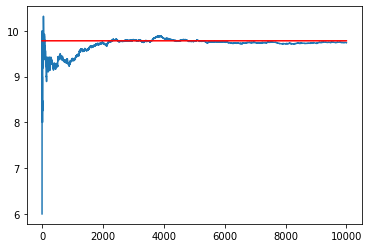

In [143]:
plt.plot(moyennes_0)
plt.plot([gains_exacts[0]]*n0, c='red')
plt.show()

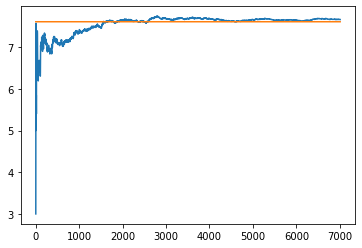

In [144]:
plt.plot(moyennes_1)
plt.plot([gains_exacts[1]]*n1)
plt.show()

exercice : comparer le MC every visit

# TD(0)

In [247]:
def TD0(env, nb_episodes, alpha, gamma=1):
    gains = np.array([0.]*env.nb_states)
    suite_gains = [np.copy(gains)]
    for n in range(nb_episodes):
        state = env.reset()
        terminal = False
        
        while not terminal:
            new_state, rew, terminal, info = env.step()
            cible = rew + gamma*gains[new_state]
            gains[state] = (1-alpha)*gains[state] + alpha*cible
            state = new_state
            
        suite_gains.append(np.copy(gains))

    return gains, suite_gains

In [251]:
gain, suite = TD0(env, 100000, 0.001)

In [252]:
suite[-1]

array([9.77455912, 7.62379004, 0.        ])

In [249]:
suite = np.array(suite)
gains0 = suite[:,0]
gains1 = suite[:,1]
n0 = len(gains0)

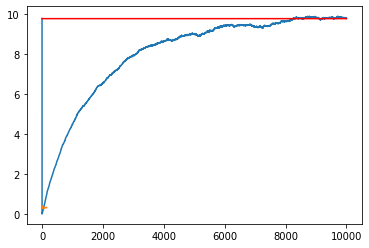

In [186]:
plt.plot(gains0)
plt.plot(moyennes_0)
plt.plot([gains_exacts[0]]*n0, c='red')
plt.show()

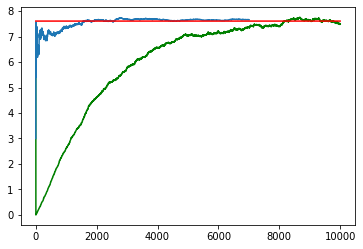

In [189]:
plt.plot(gains1, c='green')
plt.plot(moyennes_1)
plt.plot([gains_exacts[1]]*n0, c='red')
plt.show()

In [188]:
import gym


In [117]:
class Frozen_lake_random_MRP:
    def __init__(self):
        self.fl = gym.make('FrozenLake-v0',size=4)
        self.nb_states = self.fl.observation_space.n
        
    def step(self):
        return self.fl.step(self.fl.action_space.sample())
    
    def reset(self):
        return self.fl.reset()
    

In [118]:
env_fl = Frozen_lake_random_MRP()

In [119]:
env_fl.reset()

0

In [120]:
env_fl.step()

(0, 0.0, False, {'prob': 0.3333333333333333})

In [220]:
gains_MC = first_visit_gain_MC(env_fl,100000, gamma = 1)

In [221]:
gains0 = np.array(gains_MC[0])
n0=len(gains0)
moyennes_0 = [gains0[:i+1].mean() for i in range(n0)]
moyennes_0[-1]

0.01367

In [237]:
[np.array(gains_MC[i]).mean() for i in range(16)]

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.


[0.01367,
 0.011617212837020184,
 0.02073995289827547,
 0.01015583960777447,
 0.015731709276727034,
 nan,
 0.04035542391706775,
 nan,
 0.034132771972032176,
 0.08471760797342193,
 0.14198926250353208,
 nan,
 nan,
 0.16678823243374666,
 0.43562778840025496,
 nan]

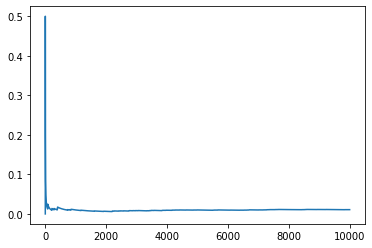

In [214]:
plt.plot(moyennes_0)
plt.show()

In [255]:
gains_TD, suite_TD = TD0(env_fl,100000,alpha=0.001,gamma=1) 

In [256]:
gainsTD0 = np.array(suite_TD)[:,0]
n0=len(gainsTD0)
moyennesTD_0 = [gainsTD0[:i+1].mean() for i in range(n0)]

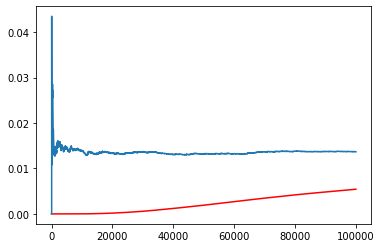

In [257]:
plt.plot(moyennesTD_0, c='red')
plt.plot(moyennes_0)
plt.show()

In [259]:
suite_TD[-1]

array([0.01163279, 0.0094627 , 0.01680765, 0.00817028, 0.01406357,
       0.        , 0.03381467, 0.        , 0.0298427 , 0.07589851,
       0.12150881, 0.        , 0.        , 0.14858228, 0.41123703,
       0.        ])

In [190]:
env_fl.reset()

0

In [203]:
env_fl.fl.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


In [254]:
env_fl.fl.unwrapped.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

In [283]:
#valeur exacte
P_FL = np.array([[0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0],
                 [1/3.0,0.,1/3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                 [0.,1/3.0,0.,1/3.0,0.0,1/3.0,0.0,0.0,0.0,0.0,0.0],
                 [0.,0.,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
                 [1/3.0,0.,0.,0.0,0.0,0.0,1/3.0,0.0,0.0,0.0,0.0],
                 [0.,0.,0.25,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0],
                 [0.,0.,0.,0.0,1/3.0,0.0,0.0,1/3.0,0.0,0.0,0.0],
                 [0.,0.,0.,0.0,0.0,0.0,0.25,0.0,0.25,0.25,0.0],
                 [0.,0.,0.,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.25],
                 [0.,0.,0.,0.0,0.0,0.0,0.0,1/3.0,0.0,0.0,1/3.0],
                 [0.,0.,0.,0.0,0.0,0.0,0.0,0.0,1/3.0,1/3.0,0.0]])           
                

In [284]:
P_FL.shape

(11, 11)

In [285]:
R = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1/3.0]).reshape(11,1)

In [286]:
print(np.linalg.inv(np.identity(11)-P_FL).dot(R))

[[0.0139398 ]
 [0.01163093]
 [0.02095299]
 [0.01047649]
 [0.01624867]
 [0.04075154]
 [0.0348062 ]
 [0.08816993]
 [0.14205316]
 [0.17582037]
 [0.43929118]]


In [276]:
[np.array(gains_MC[i]).mean() for i in range(16)]

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/david/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.01367,
 0.011617212837020184,
 0.02073995289827547,
 0.01015583960777447,
 0.015731709276727034,
 nan,
 0.04035542391706775,
 nan,
 0.034132771972032176,
 0.08471760797342193,
 0.14198926250353208,
 nan,
 nan,
 0.16678823243374666,
 0.43562778840025496,
 nan]

In [278]:
envbis = gym.make('FrozenLake-v0',map_name="4x4")

In [279]:
envbis.render()


SFFF
FHFH
FFFH
HFFG
